# This is a work in progress... Text/questions will be added in the next couple weeks

Argovis offers a growing list of gridded products, indexed and downloadable through its API. In this notebook, we'll use the Argovis API to describe ENSO.

> **This is a beta product!**
> Argovis' new API is currently undergoing heavy development. Therefore, everything in these notebooks should be understood as a technical preview only; implementation details may change before a 
stable release is made. Please send feedback and ideas to argovis@colorado.edu, and see the API docs as they evolve at https://argovis-api.colorado.edu/docs/.

## Setup

In addition to importing a few python packages, make sure to plug in your Argovis API key for `API_KEY` in the next cell. If you don't have a free Argovis API key yet, get one at https://argovis-keygen.colorado.edu/.

In [1]:
import requests, xarray, pandas, math, datetime, copy
import numpy as np
from datetime import datetime, timedelta
from argovisHelpers import helpers as avh
import matplotlib.pyplot as plt
from scipy import signal

from grids_helper import create_boxstr_for_query,query_grid_by_region_month_year,\
                         areaweighted_region_mean,plot_section,plot_map

API_KEY=''
API_PREFIX = 'https://argovis-api.colorado.edu/'

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

## Downloading Gridded Data

Argovis supports a number of grids through the same API endpoints. Let's begin by discovering what grids are available:

In [3]:
grids = avh.query('grids/vocabulary', options={'parameter':'data_keys'}, apikey=API_KEY, apiroot=API_PREFIX)
grids

['ohc_kg', 'salinity_rg', 'temperature_rg']

For more info on the ONI, see https://www.climate.gov/news-features/understanding-climate/climate-variability-oceanic-ni%C3%B1o-index.

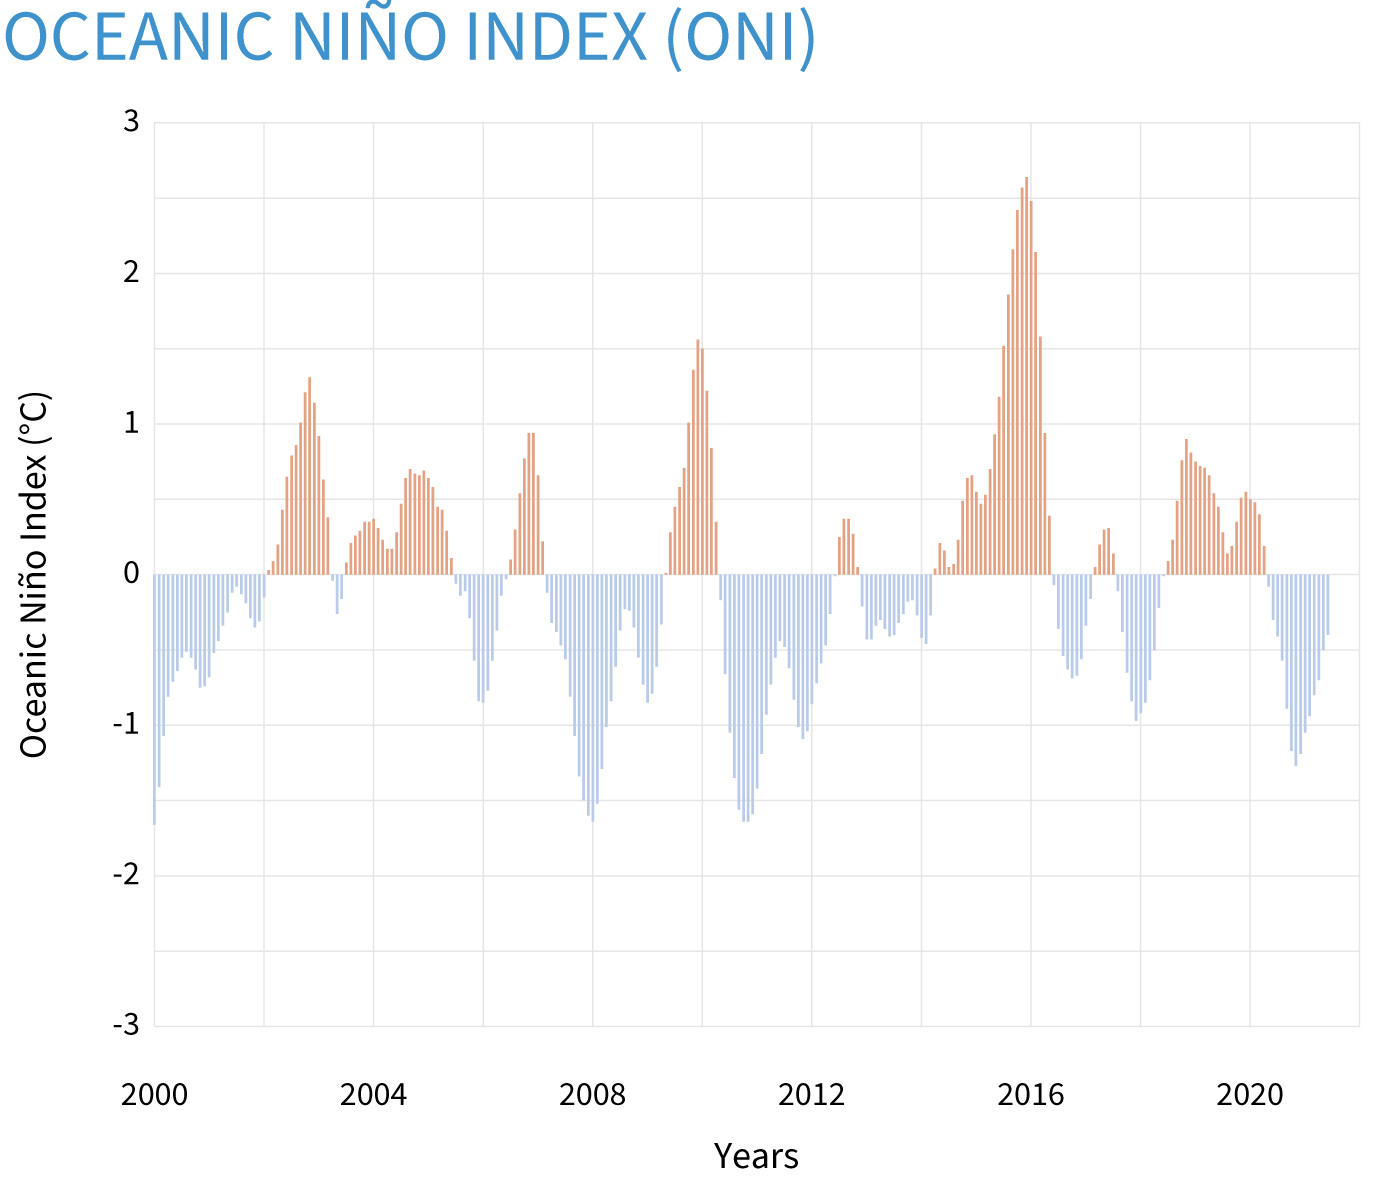

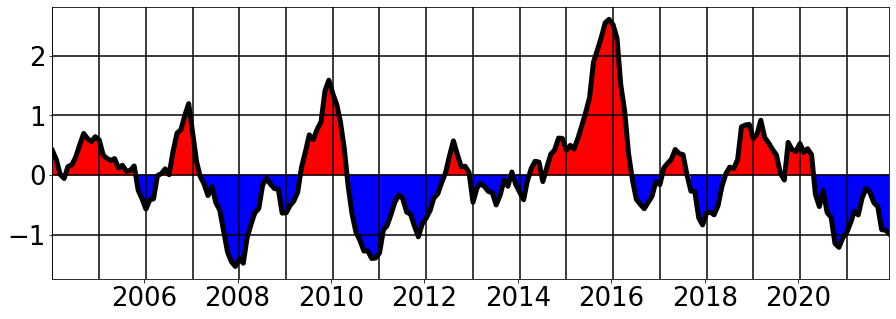

In [4]:
# These parameters should be left as is:
year_nino    = 2015
year_nina    = 2007
year_neutral = 2013

latitude_south = -8.5
latitude_north = 8.5

longitude_west = 150
longitude_east = -130

month= 12 # i.e. December

grid_name = 'temperature_rg' #'presRange'] = '0,100'
levels    = '0,5'
day_grid  = 15  
plot_title= 'Temperature, degC'

font_size ='26'

In [5]:
# # this is commented out as it would request too much data too quickly as is (it was ran earlier and the figures included below)
# font_size_map='32'
# for year in [year_neutral,year_nino,year_nina]:
#     data = query_grid_by_region_month_year(grid_name=grid_name,\
#                                         region_str = create_boxstr_for_query(longitude_west=longitude_west,\
#                                                                              longitude_east=longitude_east, \
#                                                                              latitude_south=latitude_south,\
#                                                                              latitude_north=latitude_north), \
#                                         long_conversion_type='long20_380',\
#                                         levels=levels,\
#                                         month_start=month,year_start=year,\
#                                         month_end=month,year_end=year,\
#                                         API_KEY=API_KEY,API_PREFIX=API_PREFIX)
#     plot_map(data=data["data"].mean(dim="time").mean(dim="pressure"),cf_levels=np.arange(22,33,1),\
#             ylim_bottom=latitude_south+1,ylim_top=latitude_north-1,plot_title=str(year) + ' ' + plot_title,font_size=font_size)

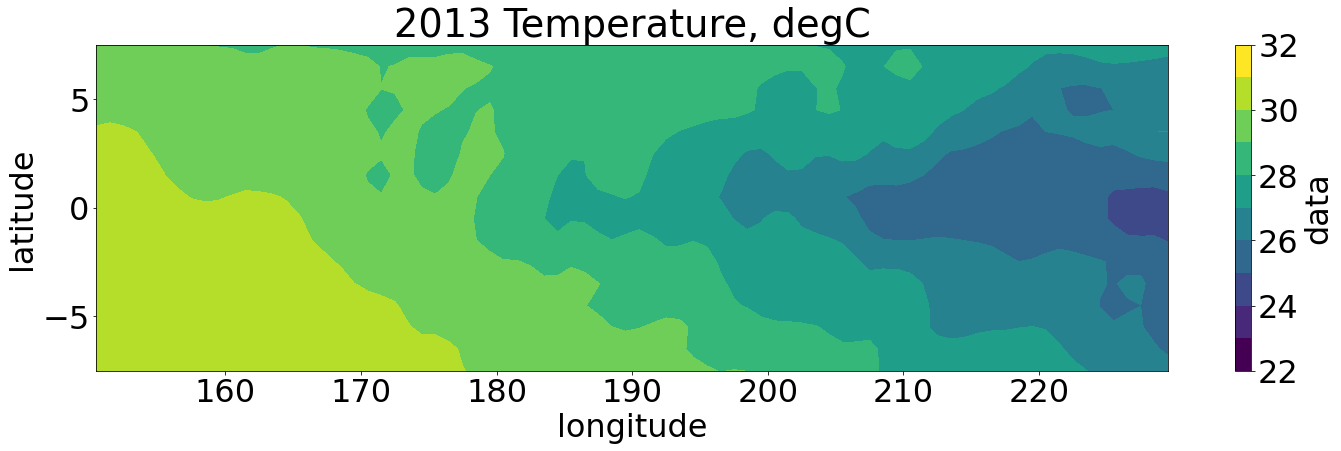

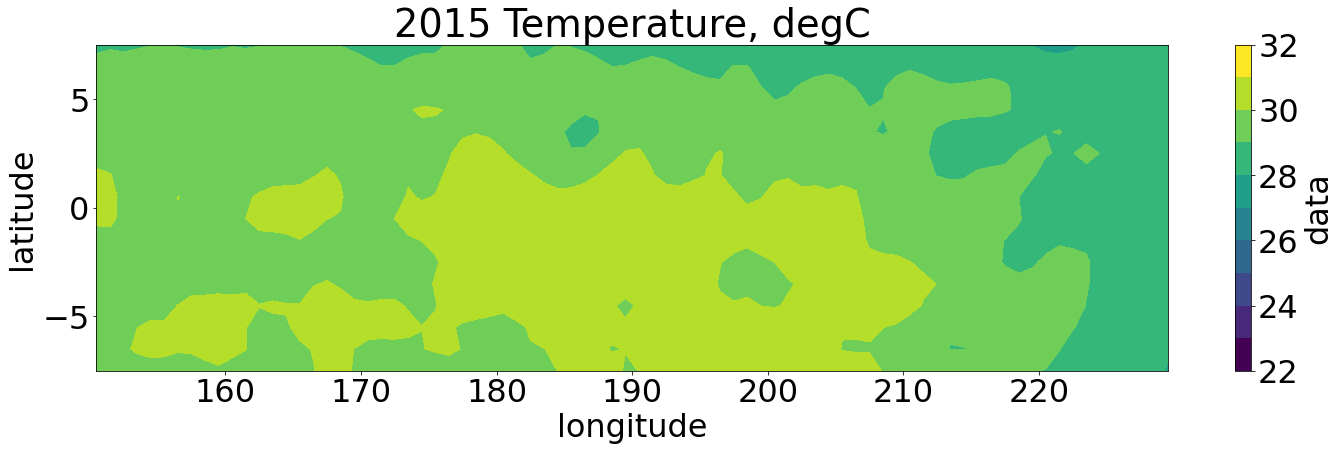

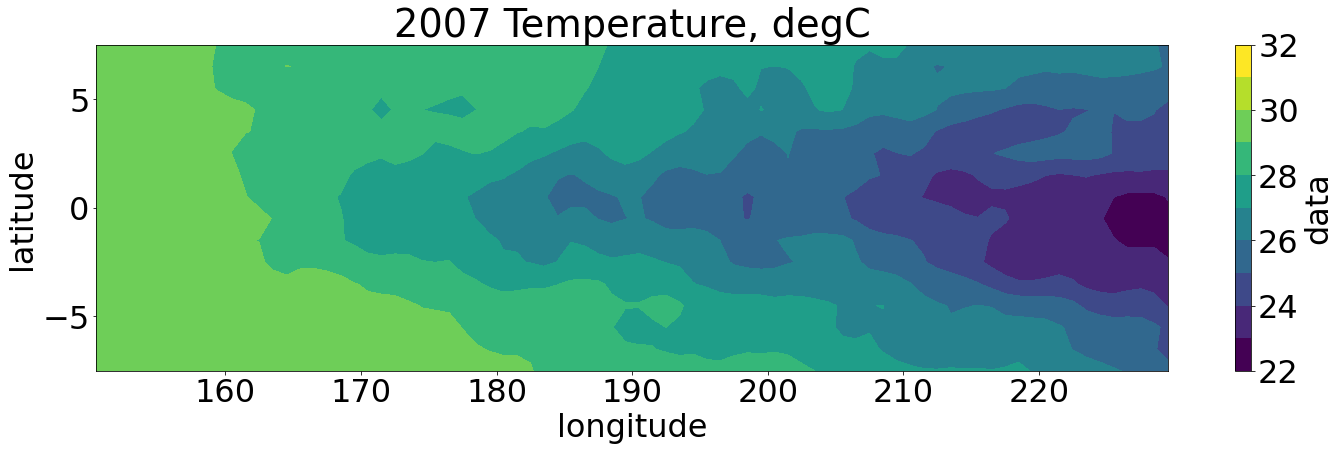

In [6]:
# to select by students
latitude_south_section = -0.5
latitude_north_section = 0.5

# to keep as is:
levels_section    = '0,250'

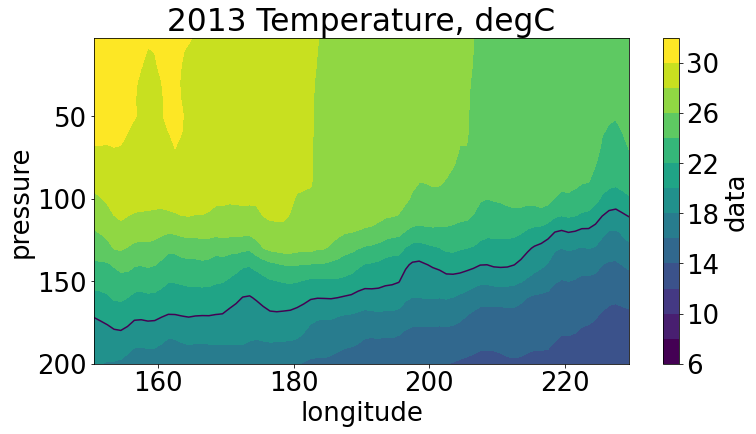

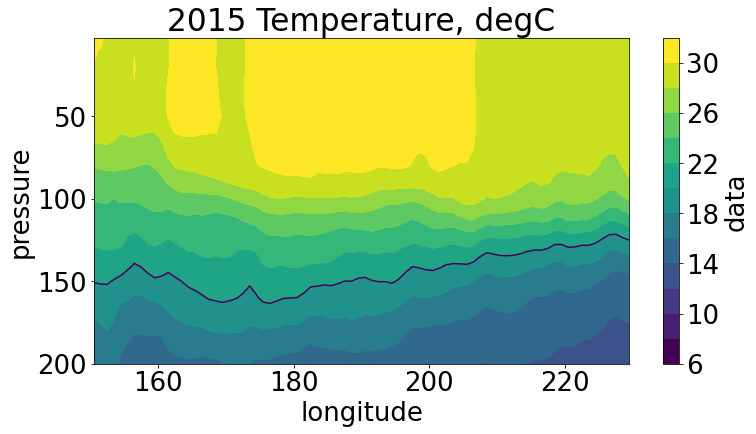

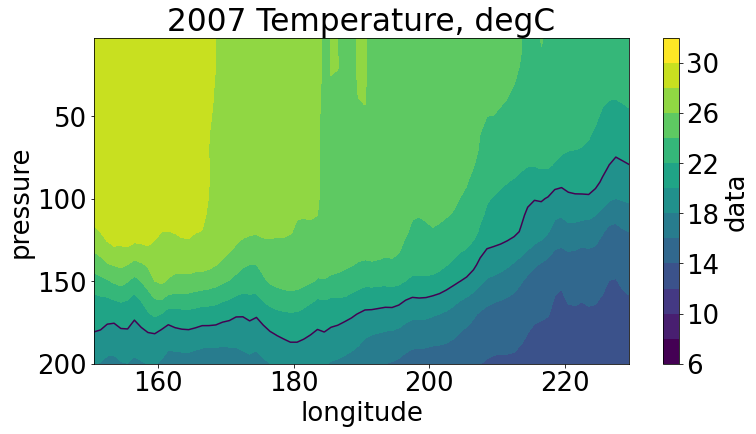

In [7]:
for year in [year_neutral,year_nino,year_nina]:
    data = query_grid_by_region_month_year(grid_name=grid_name,\
                                        region_str = create_boxstr_for_query(longitude_west=longitude_west,\
                                                                             longitude_east=longitude_east, \
                                                                             latitude_south=latitude_south_section,\
                                                                             latitude_north=latitude_north_section), \
                                        long_conversion_type='long20_380',\
                                        levels=levels_section,\
                                        month_start=month,year_start=year,\
                                        month_end=month,year_end=year,\
                                        API_KEY=API_KEY,API_PREFIX=API_PREFIX)
    plot_section(data=data["data"].mean(dim="latitude").mean(dim="time"),xaxis=data["longitude"],yaxis=data["pressure"],\
                 cf_levels=np.arange(6,34,2),cf_levels_line=np.arange(20,22,4),\
                 ylim_bottom=200,plot_title=str(year) + ' ' + plot_title,font_size=font_size)
# print(data)

In [8]:
####

# The query below takes about 5 minutes, hence is commented out now (the resulted plot was included above)

In [ ]:
latitude_south_index = -5
latitude_north_index = 5

longitude_west_index = -170
longitude_east_index = -120

levels_index    = '0,5'

data = query_grid_by_region_month_year(grid_name=grid_name,\
                                        region_str = create_boxstr_for_query(longitude_west=longitude_west_index,\
                                                                             longitude_east=longitude_east_index, \
                                                                             latitude_south=latitude_south_index,\
                                                                             latitude_north=latitude_north_index), \
                                        long_conversion_type='long20_380',\
                                        levels=levels_index,\
                                        month_start=1,year_start=2004,\
                                        month_end=12,year_end=2021,\
                                        API_KEY=API_KEY,API_PREFIX=API_PREFIX)

In [ ]:
# compute anomalies
data_reg_ave = areaweighted_region_mean(dxr=data.mean(dim="pressure"))
data_reg_ave_detrend = data_reg_ave*0 + signal.detrend(data_reg_ave["data"])
climatology = data_reg_ave_detrend.groupby("time.month").mean("time")
data_reg_ave_anom   = data_reg_ave_detrend.groupby("time.month") - climatology

In [ ]:
plt.figure(figsize=(15, 5))

for n in np.arange(-1,3,1):
    plt.axhline(y = n,color='k')
for n in np.arange(0,len(data_reg_ave_anom["time"]),12):
    plt.axvline(x = data_reg_ave_anom["time"].to_numpy()[n],color='k')
#data_reg_ave_anom["data"].plot(size=10,aspect=3)
plt.plot(data_reg_ave_anom["time"].to_numpy(),data_reg_ave_anom["data"],linewidth=5,color='k')
plt.xlim([data_reg_ave_anom["time"].to_numpy()[0],data_reg_ave_anom["time"].to_numpy()[-1]])

plt.gca().fill_between(data_reg_ave_anom["time"].to_numpy(),\
                       data_reg_ave_anom["data"],\
                       where=(data_reg_ave_anom["data"]>0),color='red')
plt.gca().fill_between(data_reg_ave_anom["time"].to_numpy(),\
                       data_reg_ave_anom["data"],\
                       where=(data_reg_ave_anom["data"]<0),color='blue')
plt.show()

In [ ]:
# # plots
# climatology["data"].plot(size=10,aspect=3)
# data_reg_ave["data"].plot(size=10,aspect=3)
# data_reg_ave_detrend["data"].plot(size=10,aspect=3)
# #
